Figures in the paper, organized version

In [2]:
%matplotlib inline
import matplotlib, re, os, itertools
from matplotlib_venn import venn3,venn2, venn3_unweighted
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from collections import OrderedDict
import glob
import seaborn as sns
from scipy import stats, optimize
# from Bio.SubsMat import MatrixInfo

In [3]:
# at-home imports
sns.set_context('paper',font_scale=3)
sns.set_palette("colorblind")
def concatenate_csvs(csvpath,vf=False):
    directory= os.fsencode(csvpath)
    def sub_conversion(list_aa):
        if len(list_aa)==2:
            codes={'Cys': 'C', 'Asp': 'D', 'Ser': 'S', 'Gln': 'Q', 'Lys': 'K','Trp': 'W', 'Asn': 'N', 'Pro': 'P', 'Thr': 'T', 'Phe': 'F', 'Ala': 'A','Gly': 'G', 'Ile': 'X', 'Leu': 'X', 'Xle': 'X', 'His': 'H', 'Arg': 'R', 'Met': 'M','Val': 'V', 'Glu': 'E', 'Tyr': 'Y'}
            new_list=[]
            for l in list_aa:
                new_list.append(codes[l])
            return(','.join(new_list)) #can also be a tuple later if desired
        return('')
    values={'unexpected_modification':'none'}
    ionbotout=pd.read_csv(csvpath)
    ionbotout=ionbotout[ionbotout['ri_126.1277']>0]
    # ionbotout['scan_id']=ionbotout['title'].str.split(' ').apply(lambda x: x[0]) #get unique identifier in the title column
    ionbotout=ionbotout.drop(['ri_126.1277','ri_127.1311','ri_128.1344','ri_129.1378','ri_130.1411','ri_131.1382'],axis=1)
    ionbotout["DB"]=ionbotout["DB"].map({'D':True,'T':False})
    ionbotout['peptide']=ionbotout['matched_peptide'].str.replace('I|L','x',regex=True)
    if vf:
        ionbotout['pred_aa_sub']=ionbotout['modifications'].apply(lambda x: re.findall('[A-Z]{1}[a-z]{2}->[A-Z]{1}[a-z]{2}\[[A-Z]{1}\]',x)).apply(lambda y: re.findall('[A-Z]{1}[a-z]{2}',y[0]) if len(y)>0 else '').apply(sub_conversion)
    return(ionbotout)

def il_sensitive_read_csv(csvpath,to_replace=['peptide','ref_counterpart']):
    '''read in the variant peptides and counterparts, replace 
    '''
    #names may change if add substitution/variant status: ['protein','variant','counterpart','sub','start','chr','genomic_pos','is_het']
    df=pd.read_csv(csvpath)
    for col in to_replace:
        original=col+'_original'
        df[original]=df[col]
        df[col]=df[col].replace(to_replace='I|L',value='x',regex=True)
    df['substitution']=df['substitution'].str.replace('I','X').str.replace('L','X')
    return(df.rename({'peptide':'variant_peptide'},axis=1))

final_variantset_vc=pd.read_csv('~/Dropbox/ionbot/with_crap/variants_vc.csv').drop_duplicates('title')
final_variantset_vf=pd.read_csv('~/Dropbox/ionbot/with_crap/variants_vf.csv').drop_duplicates('title')
variant_peptides=il_sensitive_read_csv('~/Dropbox/ionbot/variant_peps_plus_origin.csv')


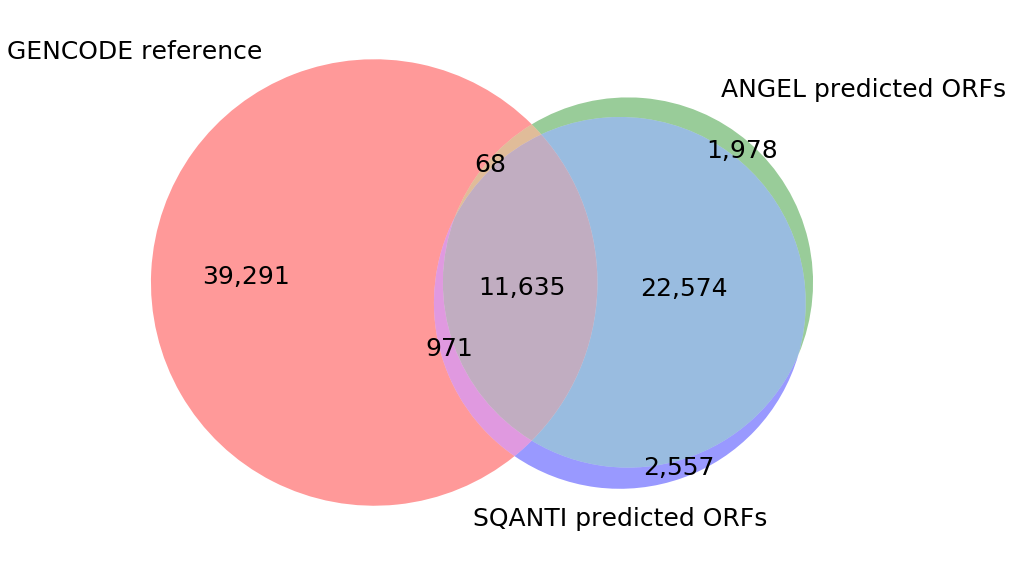

In [8]:
# figure 2A
from matplotlib_venn import venn3
plt.figure(figsize=(16,10))
v=venn3(subsets = (40905, 2557, 68, 1978, 971, 22574, 11635), set_labels = ('GENCODE reference', 'ANGEL predicted ORFs', 'SQANTI predicted ORFs'))
labels = {'100':'39,291', '001':'2,557', '110':'68', '010':'1,978', '101':'971', '011':'22,574', '111':'11,635'}
[v.get_label_by_id(label).set_text(val) for label,val in labels.items()]
for text in v.set_labels:
    text.set_fontsize(25)
for text in v.subset_labels:
    text.set_fontsize(25)

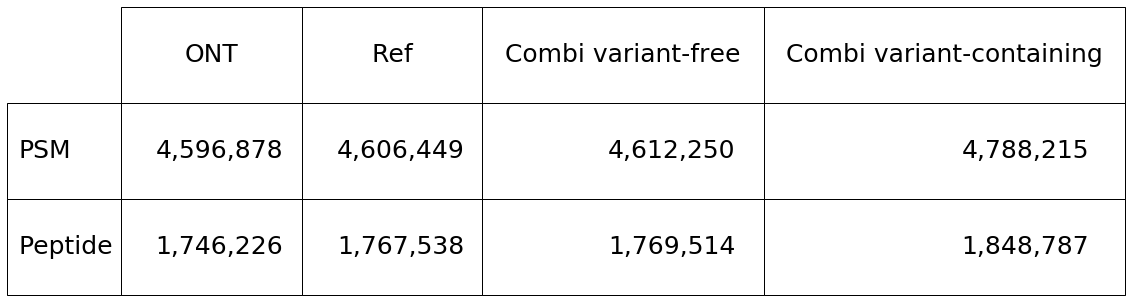

In [11]:
#make table
def graph_table():
    nrows, ncols = 3, 4
    hcell, wcell = 0.1, 0.1 # tweak as per your requirements
    hpad, wpad = 0.5, 0.5    
    fig=plt.figure(figsize=(ncols*wcell+wpad, nrows*hcell+hpad))
    ax=fig.add_subplot(111)
    ax.axis("off")
    ax.axis("tight")
    table=ax.table(cellText=[['4,596,878','4,606,449','4,612,250','4,788,215'],['1,746,226','1,767,538','1,769,514','1,848,787']],colWidths = [0.45, 0.45,0.7, 0.9],rowLabels=['PSM','Peptide'],colLabels=['ONT','Ref','Combi variant-free', 'Combi variant-containing'],loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(25)
    table.scale(8, 8)

graph_table()

<Figure size 432x288 with 0 Axes>

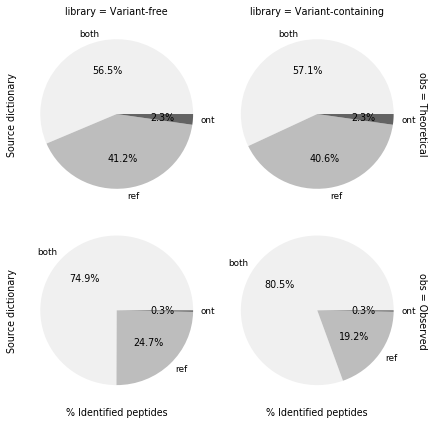

In [5]:
# Figure 2C
#sources
source_obs_vf=pd.read_csv('~/Dropbox/ionbot/with_crap/sources_psm_obs_varfree.png.csv',names=['source_dictionary','count'])
source_obs_vc=pd.read_csv('~/Dropbox/ionbot/with_crap/sources_psm_obs_varcont.png.csv',names=['source_dictionary','count'])#index_col=0,header=None).transpose()
source_th_vf=pd.read_csv('~/Dropbox/ionbot/with_crap/sources_psm_theoretical_varfree.png.csv',names=['source_dictionary','count'])
source_th_vc=pd.read_csv('~/Dropbox/ionbot/with_crap/sources_psm_theoretical_varcont.png.csv',names=['source_dictionary','count'])
source_obs_vf['obs']='Observed'
source_obs_vf['library']='Variant-free'
source_obs_vc['obs']='Observed'
source_obs_vc['library']='Variant-containing'
source_th_vf['obs']='Theoretical'
source_th_vf['library']='Variant-free'
source_th_vc['obs']='Theoretical'
source_th_vc['library']='Variant-containing'

def plot_source_piechart(source):
    '''this function will plot the source piechart of sources of the hits and save it to a pdf'''
    plt.figure('source piechart')
    sns.set_context("paper")
    sns.dark_palette("grey",n_colors=3)
    labels='Exclusively ONT transcriptome','Exclusively reference (gencode)', 'Both'
    def pie(v, l, color=None):
        explode = (0, 0, 0.1)
        plt.pie(v, labels=l.values,autopct='%1.1f%%',colors=['#f0f0f0','#bdbdbd','#636363'])
    g = sns.FacetGrid(source, col="library",row='obs',margin_titles=True)# ,gridspec_kws={"right":0.8})
    g.map(pie,'count','source_dictionary').fig.subplots_adjust(wspace=.05, hspace=.05)
#     plt.pie([source['ont'],source_counter['ref'],source_counter['both']],autopct='%1.1f%%', explode=explode,colors=['#de2d26','#3182bd','#756bb1'])
    # plt.title('Peptide spectral hits by source',fontsize=35)
    g.set_axis_labels('% Identified peptides','Source dictionary')
    
plot_source_piechart(pd.concat([source_th_vf,source_th_vc,source_obs_vc,source_obs_vf],ignore_index=True))

<Figure size 432x288 with 0 Axes>

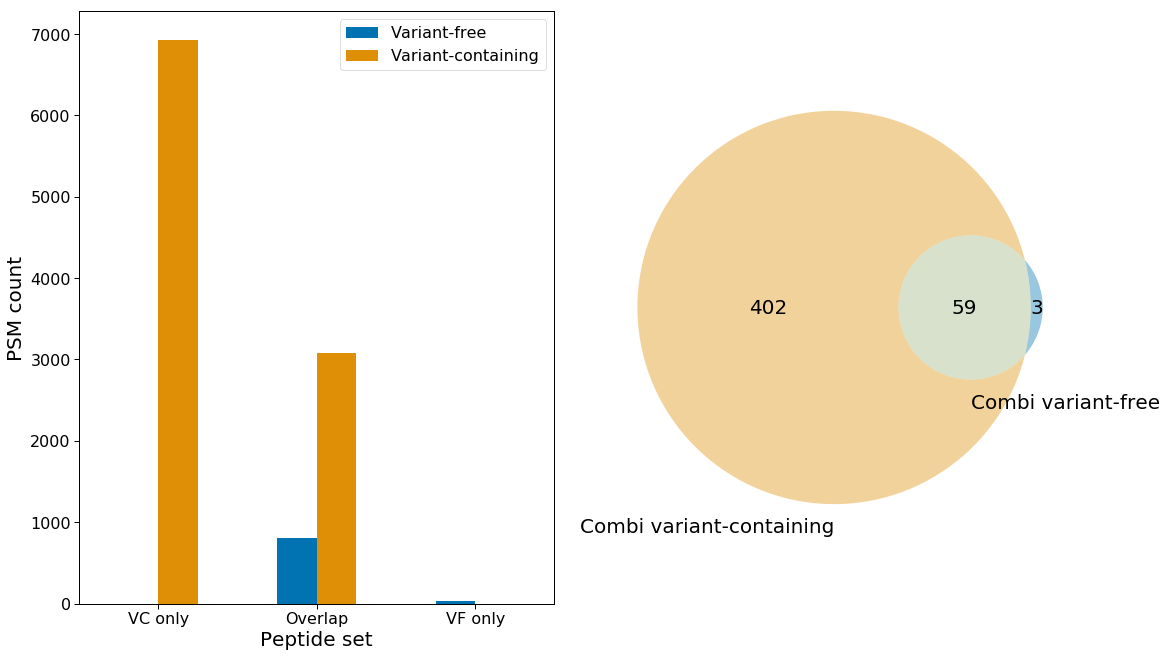

In [6]:
# Figure 3B/C
def create_overlap_df(df_vc,df_vf):
    def label_merge(ind):
        if ind=='right_only':
            return('A')
        elif ind=='both':
            return('B')
        else:
            return('C')
    overlap=pd.DataFrame(df_vf['variant_peptide'].value_counts()).reset_index().merge(pd.DataFrame(df_vc['variant_peptide'].value_counts()).reset_index(),on='index',how='outer',suffixes=('_vf','_vc'),indicator=True).rename({'_merge':'library','variant_peptide_vc':'Variant-containing','variant_peptide_vf':'Variant-free'},axis=1)
    overlap['sort']=overlap['library'].apply(label_merge)
    return(overlap)
    

def plot_final_venns(df_vc,df_vf):
    ov1=create_overlap_df(df_vc,df_vf)
#     ov2=create_overlap_df(df_vc,prelim_vf)
    #create diagrams
    plt.figure('venn variant psms')
    sns.set_context("paper",font_scale=4)
    sns.set_palette("colorblind")
    fig, axs=plt.subplots(1,2,figsize=(16,10))
    #vda=venn2([vc,vf],('Combi variant-containing','Combi variant-free'),ax=ax1) #venn for the overlap in detected peptides
    ov1.groupby('library').agg(sum).rename({'right_only':'VC only','left_only':'VF only','both':'Overlap'}).reindex(['VC only','Overlap','VF only']).plot.bar(ax=axs[0],rot=0,fontsize=16)
    v1=venn2([set(ov1.loc[ov1['Variant-containing']>0,'index'].unique()),set(ov1.loc[ov1['Variant-free']>0,'index'].unique())],set_labels = ("Combi variant-containing","Combi variant-free"),set_colors=('#de8f05','#0173b2'),ax=axs[1]) #venn for the overlap in detected proteins
#     v2=venn2([set(ov2.loc[ov2['Variant-containing']>0,'index'].unique()),set(ov2.loc[ov2['Variant-free']>0,'index'].unique())],set_labels = ("Combi variant-containing","Combi variant-free"),set_colors=('tab:orange','tab:blue'),ax=axs[1,0]) #venn for the overlap in detected proteins
#     axs[0].set_title("Observed variant PSMs",fontsize=20)
    axs[0].set_ylabel('PSM count',fontsize=20)
    axs[0].set_xlabel('Peptide set',fontsize=20)
    axs[0].legend(prop={'size': 16})
#     axs[1].set_title("Unique variant peptides (supported by genome)",fontsize=20)
#     axs[1,0].set_title("Unique variant peptides (not supported by genome)",fontsize=20)
#     axs[1,1].axis("off")
#     table=axs[1,1].table(cellText=[['816','1,234'],['61','72']],colWidths = [0.08, 0.08],rowLabels=['PSM','Peptide'],colLabels=['Correctly identified SAAV','Total'],loc='center')
#     table.scale(5, 5)
#     table.set_fontsize(100)
#     for v in [v1,v2]:
    for text in v1.set_labels:
        text.set_fontsize(20)
    for text in v1.subset_labels:
        text.set_fontsize(20)
    plt.tight_layout(pad=1)
        
plot_final_venns(final_variantset_vc,final_variantset_vf)#,prelim_vf_comb)

In [7]:
# Figure 3D

# get information

#prelim
prelim_vf=pd.read_csv('~/Dropbox/ionbot/with_crap/prelim_vf.csv')

#PSM
display(final_variantset_vc.drop_duplicates().shape[0]) #vc psms
display(prelim_vf.drop_duplicates().shape[0]-prelim_vf.merge(final_variantset_vf,on='title').drop_duplicates().shape[0]) #unsupported psms
display(prelim_vf.merge(final_variantset_vf,on='title').drop_duplicates().shape[0]) #supported psms
display(final_variantset_vf[final_variantset_vf['pred_aa_sub']==final_variantset_vf['substitution']].shape[0]) #psms where aa sub correctly predicted

#PEPTIDE
display(final_variantset_vc.drop_duplicates(subset='matched_peptide').shape[0]) #vc peptides
display(prelim_vf.drop_duplicates(subset='matched_peptide_vf').shape[0]-prelim_vf.merge(final_variantset_vf,on='title').drop_duplicates(subset='matched_peptide_vf').shape[0]) #unsupported peptides
display(prelim_vf.merge(final_variantset_vf,on='title').drop_duplicates(subset='matched_peptide_vf').shape[0]) #supported peptides
display(final_variantset_vf.loc[final_variantset_vf['pred_aa_sub']==final_variantset_vf['substitution'],'matched_peptide'].drop_duplicates().shape[0]) #peptides where aa sub correctly predicted #unsupported peptides


10015

41340

807

592

461

1805

61

50

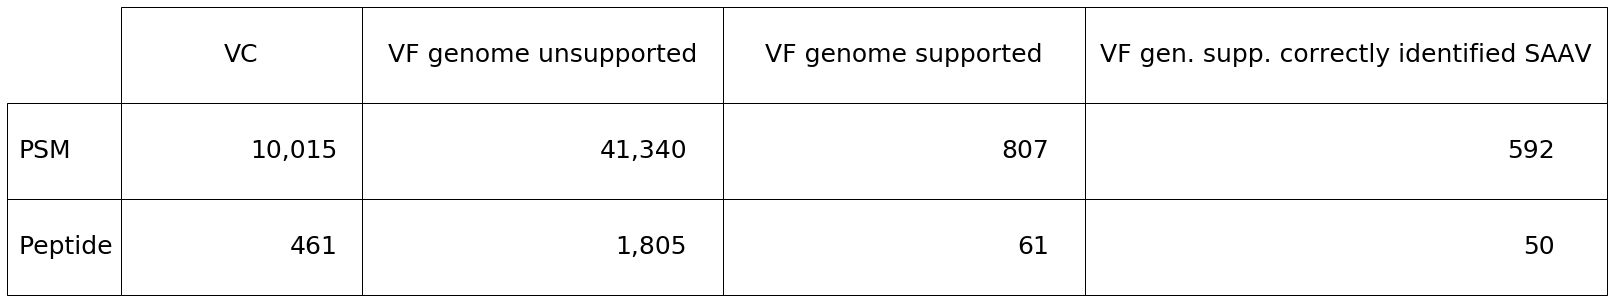

In [12]:
# graph table
def graph_table():
    nrows, ncols = 3, 4
    hcell, wcell = 0.1, 0.1 # tweak as per your requirements
    hpad, wpad = 0.5, 0.5    
    fig=plt.figure(figsize=(ncols*wcell+wpad, nrows*hcell+hpad))
    ax=fig.add_subplot(111)
    ax.axis("off")
    ax.axis("tight")
    table=ax.table(cellText=[['10,015','41,340','807','592'],['461','1,805','61','50']],colWidths = [0.6, 0.9,0.9, 1.3],rowLabels=['PSM','Peptide'],colLabels=['VC','VF genome unsupported','VF genome supported', 'VF gen. supp. correctly identified SAAV'],loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(25)
    table.scale(8, 8)
    
graph_table()

In [3]:
# Figure 4A - info here, created in illustrator
#mislabeled variant peps
mislabeled=pd.read_csv('/Users/rsalz/Dropbox/ionbot/with_crap/mislabeled_varpeps.csv')
mislabeled['pep_vf']=mislabeled['matched_peptide_vf'].replace(to_replace='I|L',value='x',regex=True)
mislabeled=mislabeled.drop_duplicates('title').merge(variant_peptides.drop_duplicates('variant_peptide').rename({'ref_counterpart':'pep_vf'},axis=1),on='pep_vf',how='left',indicator=True)
mislabeled=mislabeled[pd.isnull(mislabeled['variant_peptide'])]


peptide length statistics (KS 2samp)
t = 0.5
p = 0.001727905359252803


<Figure size 432x288 with 0 Axes>

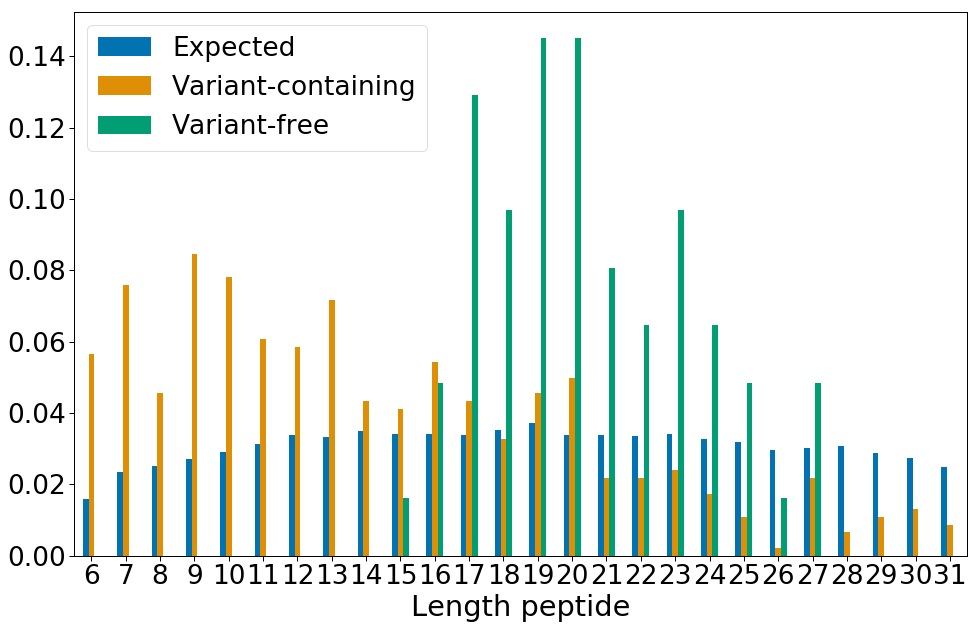

In [4]:
# Figure 4B
def plot_peplengths(list_counts,labels,legend_loc,variant=False):
    figname='variant_peptide_length.png'
    sns.set_context('paper',font_scale=3)
    plt.figure('discrepant peptide lengths')
    # new_index= [1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,'X','Y','M','unknown']
#     chist_vc=pd.DataFrame.from_dict(lenct_vc,orient='index').sort_index()
#     chist_nonvar_vc=pd.DataFrame.from_dict(lenct_nonvar_vc,orient='index').sort_index()
    combi=pd.concat(list_counts,axis=1).fillna(0)
    combi.columns=labels
    combi.plot(kind="bar",figsize=(16,10),rot=0)
    #stats to look at the difference between the 2 columns
    t2, p2 = stats.ks_2samp(combi[labels[1]],combi[labels[2]]) 
    print("peptide length statistics (KS 2samp)")
    print("t = " + str(t2))
    print("p = " + str(p2))
    # combi=combi.reindex(new_index)
#     plt.ylabel("Percentage")
    plt.xlabel("Length peptide")
    plt.legend(loc=legend_loc)
    
# plot_peplengths(normalize_counter(Counter(vcopl)),normalize_counter(Counter(vcnvpl)))
# plot_peplengths(final_variantset_vc['matched_peptide'].str.len().value_counts(normalize=True).sort_index(),final_variantset_vf['matched_peptide'].str.len().value_counts(normalize=True).sort_index(),['Variant containing','Variant_free'])

#for comparison between libraries
plot_peplengths([variant_peptides['variant_peptide'].drop_duplicates().str.len().value_counts(normalize=True).sort_index().head(26),final_variantset_vc['matched_peptide'].drop_duplicates().str.len().value_counts(normalize=True).sort_index(),final_variantset_vf['matched_peptide'].drop_duplicates().str.len().value_counts(normalize=True).sort_index()],['Expected','Variant-containing','Variant-free'], 'upper left')


Text(0.5,0,'Original AA')

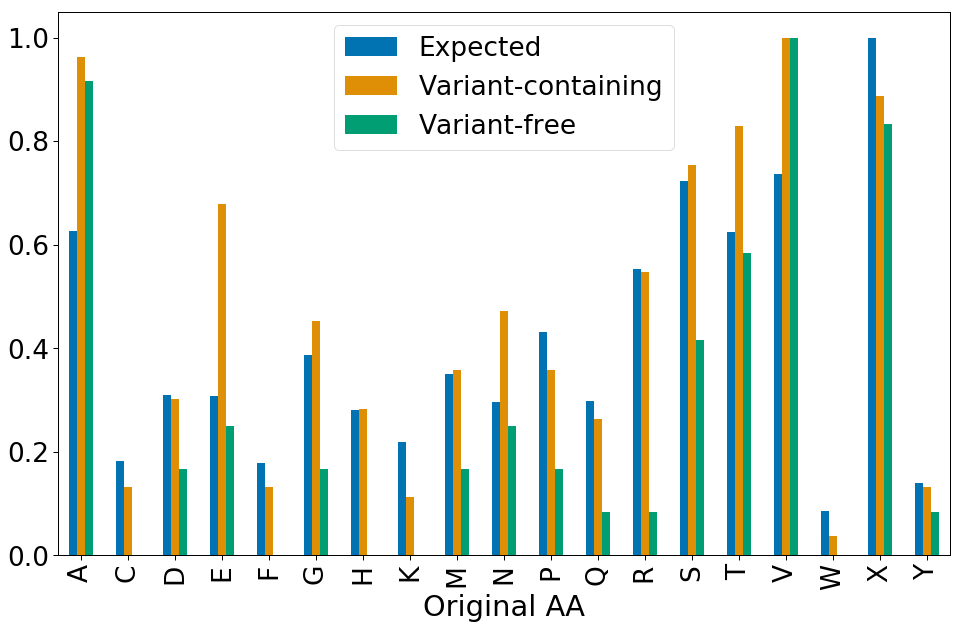

In [13]:
#Figure 4C
hm_variant_peps=variant_peptides.drop_duplicates(subset='variant_peptide')
hm_obs_vf=final_variantset_vf.drop_duplicates(subset='matched_peptide')
hm_obs_vc=final_variantset_vc.drop_duplicates(subset='matched_peptide')

def initiate_counter(half):
    '''generate all possible AA subsititutions and put them in a counter'''
    all_aa=sorted(["A", "R", "N", "D", "C", "E", "Q", "G", "H", "X", "K", "M", "F", "P", "S", "T", "W", "Y", "V"])
    if half:
        all_list=list(itertools.combinations(all_aa,2))
        all_list=[x[::-1] for x in all_list]
    else:
        all_list=list(itertools.permutations(all_aa,2))
    return(pd.DataFrame({'sub':all_list}))

def create_matrix(counter,bl=False):
    if type(counter)==dict:
        counter=pd.DataFrame.from_dict(counter,orient='index')
        counter.columns=['substitution']
        #matrix=ser.unstack()
    elif type(counter)==pd.Series:
        counter=counter.apply(lambda x: tuple(x.split(','))).value_counts()
    df=initiate_counter(bl).merge(pd.DataFrame(counter),left_on='sub',right_index=True,how='left').fillna(0).set_index('sub')
    df.index=pd.MultiIndex.from_tuples(df.index,names=('original','new'))
    df=df.groupby(by='original',axis=0).agg(sum)
    df["substitution"] = df["substitution"] / df["substitution"].max()
    return(df)#.unstack())#.to_numpy()

sns.set_context("paper",font_scale=3)
d=pd.concat([create_matrix(hm_variant_peps['substitution']),create_matrix(hm_obs_vc['substitution']),create_matrix(hm_obs_vf['substitution'])],axis=1)
d.columns='Expected','Variant-containing','Variant-free'
d.plot.bar(figsize=(16, 10))
plt.xlabel('Original AA')

<Figure size 432x288 with 0 Axes>

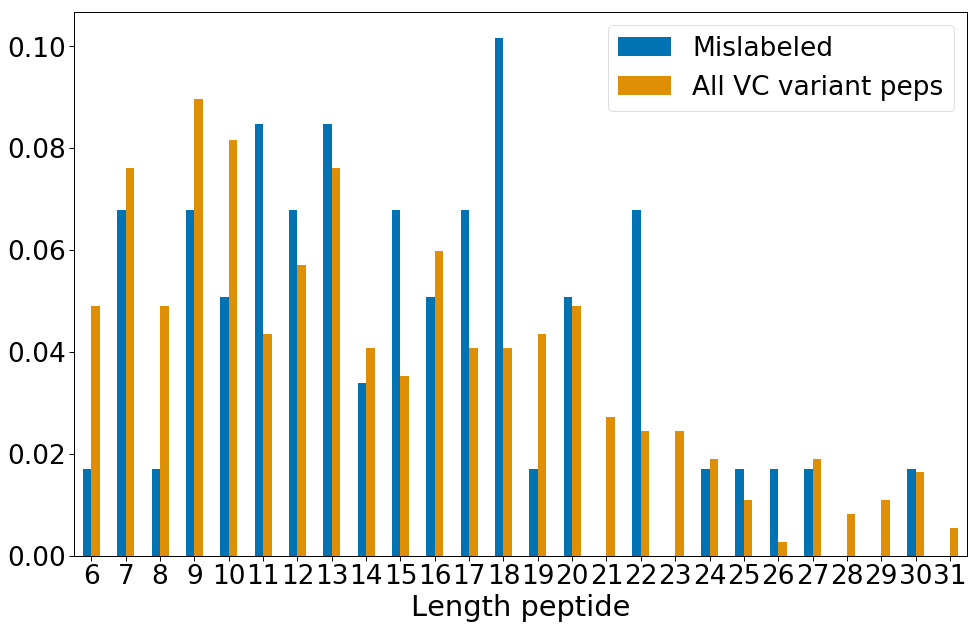

In [29]:
# Figure 5B
plot_peplengths([mislabeled['matched_peptide_vc'].drop_duplicates().str.len().value_counts(normalize=True).sort_index(),final_variantset_vc['matched_peptide'].drop_duplicates().str.len().value_counts(normalize=True).sort_index()],['Mislabeled','All VC variant peps'],'upper right')


In [22]:
# FIgure 5C

#first functions and import
def parse_mods(expected,unexpected):
    out=[]
    exptd=['','[737]tmt6plex','[4]carbamidomethyl','[35]Oxidation','[35]oxidation[M]','[35]oxidation']
    if unexpected not in exptd:
        out.append(unexpected)
    expected=expected.split('|')
    for item in expected[1::2]:
        if item.strip() not in exptd:
            if item.startswith('['):
                out.append(item)
    return(out)

def plot_unexpected_mods(mods_vf,mods_mistake_vf):
    sns.set_context('paper',font_scale=3)
    combi=pd.concat([pd.DataFrame(mods_vf.explode().fillna('None').value_counts(normalize=True).sort_values(ascending=False)),pd.DataFrame(mods_mistake_vf.explode().fillna('None').value_counts(normalize=True).sort_values(ascending=False)).head(5)],axis=1).fillna(0)#
    combi.columns=['All nonvariant VF', 'Mislabeled as nonvariant VF']
    combi=combi.sort_values('Mislabeled as nonvariant VF',ascending=False).head(5)
    combi.plot(kind='bar',figsize=(16, 10))
    plt.ylabel("% Peptides")
    plt.xlabel("PTMs")
    plt.tight_layout()
    plt.savefig('unexpected_mod.png') #uncomment when applying on the cluster
    
# all_matches_vf=concatenate_csvs('~/Downloads/vf.mgf.ionbot.csv',vf=True) #this is a fraction of all matches, the full version is on the cluster
mds=mislabeled.drop_duplicates(subset='matched_peptide_vf')#mislabeled[mislabeled['title'].isin(t)].drop_duplicates(subset='title').fillna('')#.apply(lambda x: parse_mods(x['modifications'],x['unexpected_modification']),axis=1)
mds['class']=mds.apply(lambda x: parse_mods(x['modifications'],x['unexpected_modification']),axis=1)
all_matches_vf['class']=all_matches_vf.apply(lambda x: parse_mods(x['modifications'],x['unexpected_modification']),axis=1)


/Users/rsalz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


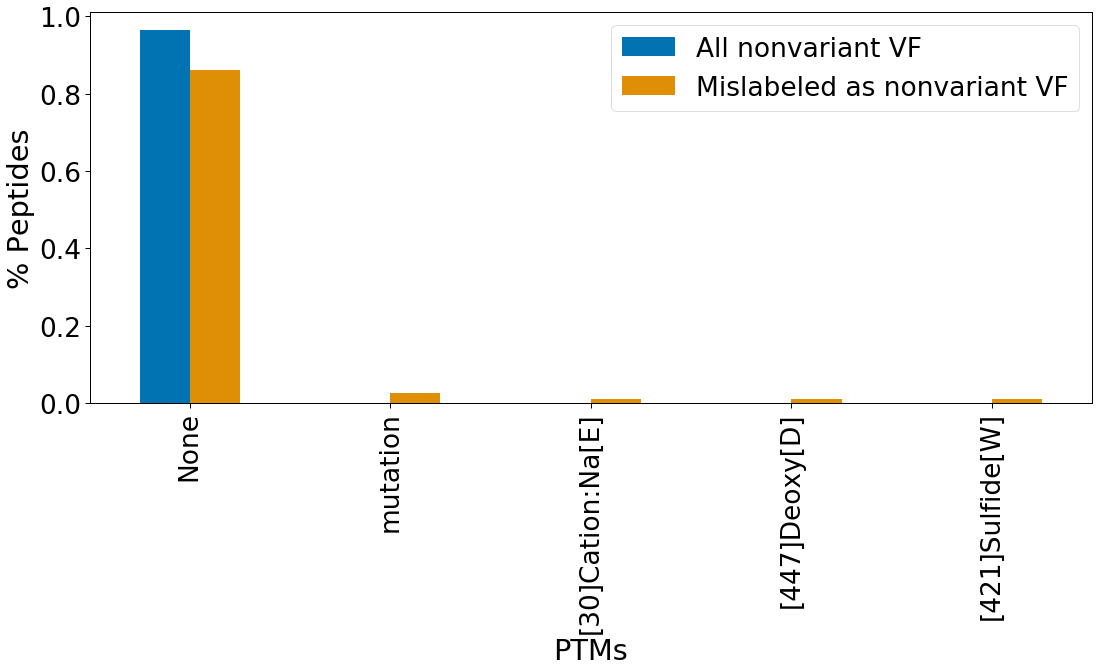

In [23]:
all_matches_vf=all_matches_vf.drop_duplicates(subset='matched_peptide')
plot_unexpected_mods(all_matches_vf['class'],mds['class'])

In [21]:
test=mds.explode('class')
test[test['class']=='[122]Formyl[S]'].drop_duplicates('title')

,title,matched_peptide_vf,modifications,unexpected_modification,best_psm_vf,ionbot_score_vf,corr_vf,percolator_psm_score_best_vf,rt,predicted_tr,...,haplotype,variant_peptide,substitution,variant_origin,var_type,_merge,vf_pep_len,vc_pep_len,aa_mismatch,class
788,"Linfeng_010211_HapMap32_8.15274.15274.3 File:""...",TQPLQHHNLLVCSVSGFYPGSIEVR,0|[737]tmt6plex|15|[122]Formyl[S]|12|[4]carbam...,[122]Formyl[S],1,0.416,92,3.313,6196.009,6863.188243,...,NaN,NaN,NaN,NaN,NaN,left_only,25,25,Mismatch: 2,[122]Formyl[S]
789,"Linfeng_010211_HapMap32_8.15303.15303.4 File:""...",TQPLQHHNLLVCSVSGFYPGSIEVR,0|[737]tmt6plex|15|[122]Formyl[S]|12|[4]carbam...,[122]Formyl[S],1,0.443,92,3.353,6206.451,6863.188243,...,NaN,NaN,NaN,NaN,NaN,left_only,25,25,NaN,[122]Formyl[S]
790,"Linfeng_010211_HapMap32_8.15330.15330.3 File:""...",TQPLQHHNLLVCSVSGFYPGSIEVR,0|[737]tmt6plex|15|[122]Formyl[S]|12|[4]carbam...,[122]Formyl[S],1,0.493,92,3.507,6214.788,6863.188243,...,NaN,NaN,NaN,NaN,NaN,left_only,25,25,NaN,[122]Formyl[S]
791,"Linfeng_010211_HapMap32_8.16460.16460.3 File:""...",TQPLQHHNLLVCSVSGFYPGSIEVR,0|[737]tmt6plex|15|[122]Formyl[S]|12|[4]carbam...,[122]Formyl[S],1,0.350,89,2.704,6602.172,6863.188243,...,NaN,NaN,NaN,NaN,NaN,left_only,25,25,NaN,[122]Formyl[S]
792,"Linfeng_010211_HapMap32_8.16465.16465.4 File:""...",TQPLQHHNLLVCSVSGFYPGSIEVR,0|[737]tmt6plex|x|[122]Formyl[S]|12|[4]carbami...,[122]Formyl[S],1,0.254,78,0.969,6603.998,6863.188243,...,NaN,NaN,NaN,NaN,NaN,left_only,25,25,NaN,[122]Formyl[S]
793,"Linfeng_010211_HapMap32_8.16503.16503.4 File:""...",TQPLQHHNLLVCSVSGFYPGSIEVR,0|[737]tmt6plex|x|[122]Formyl[S]|12|[4]carbami...,[122]Formyl[S],1,0.319,78,1.228,6618.193,6863.188243,...,NaN,NaN,NaN,NaN,NaN,left_only,25,25,NaN,[122]Formyl[S]
794,"Linfeng_010411_HapMap31_7.17464.17464.4 File:""...",TQPLQHHNLLVCSVSGFYPGSIEVR,0|[737]tmt6plex|15|[122]Formyl[S]|12|[4]carbam...,[122]Formyl[S],1,0.350,92,3.125,6862.792,6863.188243,...,NaN,NaN,NaN,NaN,NaN,left_only,25,25,NaN,[122]Formyl[S]
795,"Linfeng_011011_HapMap35_8.15303.15303.3 File:""...",TQPLQHHNLLVCSVSGFYPGSIEVR,0|[737]tmt6plex|15|[122]Formyl[S]|12|[4]carbam...,[122]Formyl[S],1,0.508,92,3.479,6233.434,6863.188243,...,NaN,NaN,NaN,NaN,NaN,left_only,25,25,NaN,[122]Formyl[S]
796,"Linfeng_011011_HapMap35_8.15381.15381.3 File:""...",TQPLQHHNLLVCSVSGFYPGSIEVR,0|[737]tmt6plex|15|[122]Formyl[S]|12|[4]carbam...,[122]Formyl[S],1,0.507,94,4.266,6260.440,6863.188243,...,NaN,NaN,NaN,NaN,NaN,left_only,25,25,NaN,[122]Formyl[S]
797,"Linfeng_011011_HapMap35_8.15399.15399.3 File:""...",TQPLQHHNLLVCSVSGFYPGSIEVR,0|[737]tmt6plex|15|[122]Formyl[S]|12|[4]carbam...,[122]Formyl[S],1,0.511,91,3.272,6266.340,6863.188243,...,NaN,NaN,NaN,NaN,NaN,left_only,25,25,NaN,[122]Formyl[S]


No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

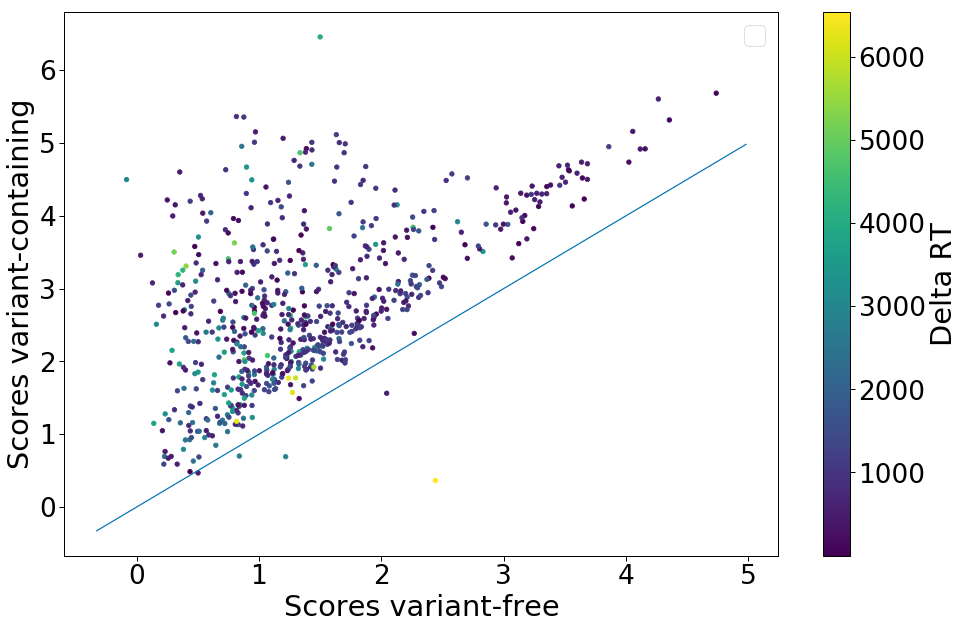

In [16]:
#Figure 5D
def plot_ib_scores_directcomp(combi):
    '''for the variant peptides that were found in one set but not another,
    what is the Percolator score distribution from each respective results list
    color by retention time prediction instead of length
    '''
    sns.set_context('paper',font_scale=3)
    plt.figure("Percolator scores discrepant hits")
    # combi.groupby("matched_peptide").mean()
#     combi.groupby("matched_peptide_vf").median() #make sure don't have groups of dots per unique peptide
    # combi["pep_length"]=combi["matched_peptide"].str.len() #record length of matched peptide (by var-free)
    # combi=pd.merge(combi,rt_pred,on='matched_peptide')
#     combi['delta_corr']=(combi['corr_vc']-combi['corr_vf']).abs()
    combi['Delta RT']=(combi['rt']-combi['predicted_tr']).abs()
#     combi['delta_ionbotscore']=(combi['ionbot_score_vc']-combi['ionbot_score_vf']).abs()
    # combi.plot.scatter(x="percolator_psm_score_varfree",y="percolator_psm_score_varcont",c="pep_length",colormap='viridis')
    combi.plot.scatter(x="percolator_psm_score_best_vf",y="percolator_psm_score_best_vc",c="Delta RT",colormap='viridis',figsize=(16,10))
    left, right = plt.xlim()
    x = np.linspace(left,right)
    plt.plot(x, x)
    # sns.distplot(varfree_scores, hist=False, label='Variant-free',axlabel='Percolator score')
    # sns.distplot(varcont_scores, hist=False, label='Variant-containing',axlabel='Percolator score')
    plt.ylabel("Scores variant-containing")
    plt.xlabel("Scores variant-free")
    plt.legend()
    
plot_ib_scores_directcomp(mislabeled.drop_duplicates().rename(columns={"matched_peptide_vc":"matched_peptide"}))

Text(0,0.5,'VF false negative peptide length')

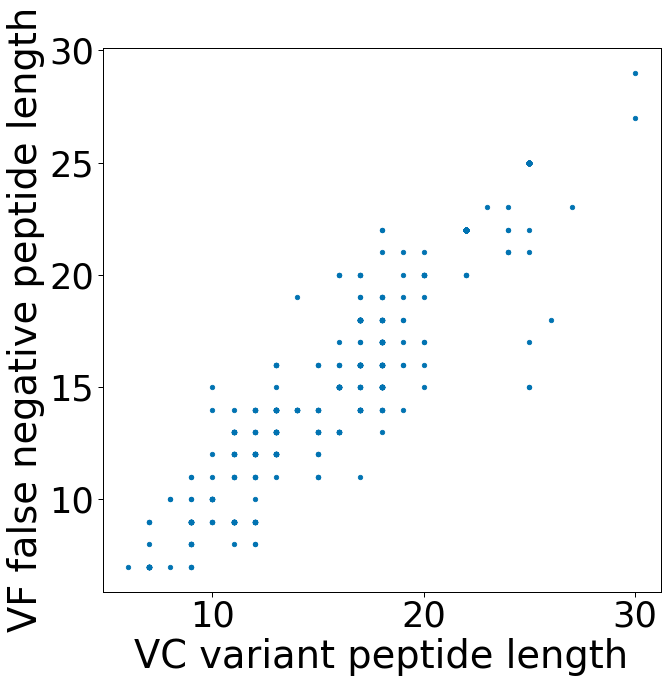

In [10]:
mislabeled['vf_pep_len']=mislabeled['matched_peptide_vf'].str.len()
mislabeled['vc_pep_len']=mislabeled['matched_peptide_vc'].str.len()
mislabeled.plot.scatter(x='vc_pep_len',y='vf_pep_len',figsize=(10,10))
plt.xlabel('VC variant peptide length')
plt.ylabel('VF false negative peptide length')


In [11]:
stats.linregress(mislabeled['vc_pep_len'], mislabeled['vf_pep_len'])

LinregressResult(slope=0.9690355514144819, intercept=0.07994270880342214, rvalue=0.9524226599048295, pvalue=0.0, stderr=0.012144319712141591)

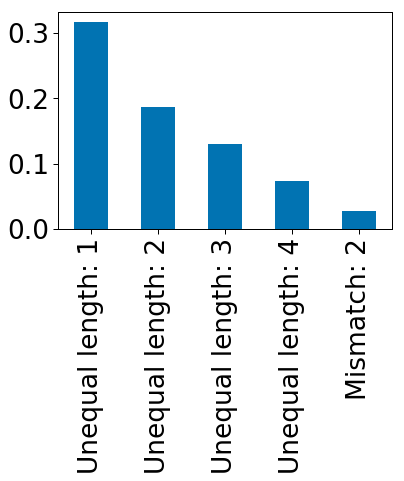

In [13]:
sns.set_context('paper',font_scale=3)
def count_mismatches(pep1,pep2):
    pep1=pep1.replace('I','X')
    if len(pep1)==len(pep2):
        mismatch=0
        for a, b in zip(pep1,pep2):
            if a!=b and a!='*' and b!='*':
                if not (a=='I' and b=='L') and not (a=='L' and b=='I'):
                    mismatch+=1
        return('Mismatch: '+str(mismatch))
    elif pep1==pep2:
        return('same')
    else:
        ue=abs(len(pep1)-len(pep2))
        return('Unequal length: '+str(ue))
    return('Unequal length')
#for unique peptides
mislabeled['aa_mismatch']=mislabeled.drop_duplicates(subset='matched_peptide_vf').apply(lambda x: count_mismatches(x['matched_peptide_vf'],x['matched_peptide_vc']),axis=1)
mislabeled['aa_mismatch'].value_counts(normalize=True).head(5).plot.bar()


In [ ]:
# Figure 6A - illustrator

/Users/rsalz/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Score')

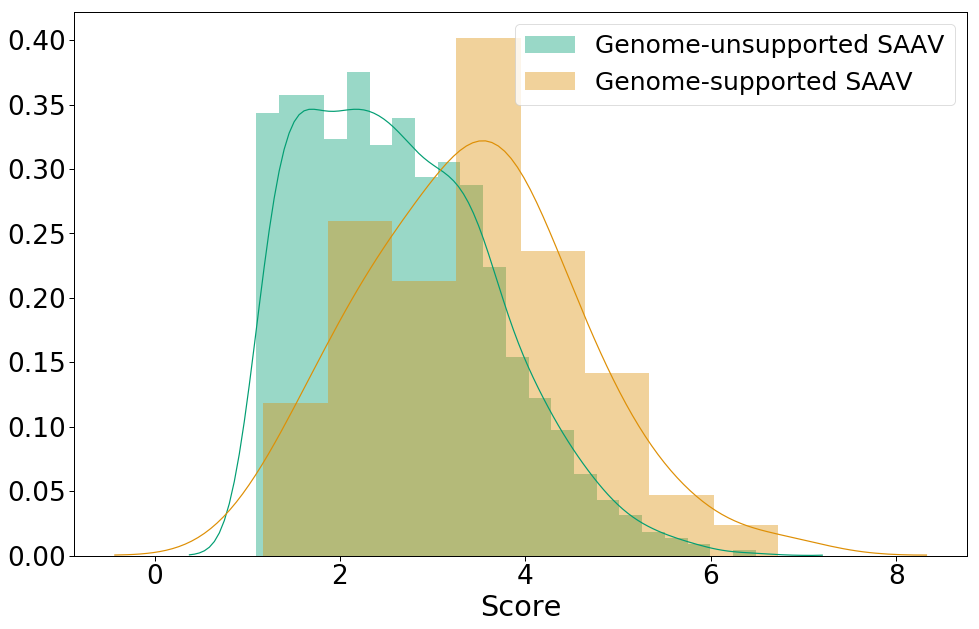

In [31]:
# Figure 6B
plt.figure(figsize=(16, 10))

prelim_vf_comb=prelim_vf.merge(final_variantset_vf[['title','variant_peptide']],on='title',how='outer')
prelim_vf_comb['variant_peptide']=prelim_vf_comb['variant_peptide'].fillna('')

pred_aa_wrong=prelim_vf_comb[prelim_vf_comb['variant_peptide']==''].drop_duplicates(subset='matched_peptide_vf') #ionbot false positive
pred_aa_right=prelim_vf_comb[prelim_vf_comb['variant_peptide']!=''].drop_duplicates(subset='matched_peptide_vf') #ionbot true positive

stats.ks_2samp(pred_aa_wrong['percolator_psm_score_best_vf'],pred_aa_right['percolator_psm_score_best_vf'])

# pred_aa_wrong['percolator_psm_score_best_vf']

##plot score dist
ax=sns.distplot(pred_aa_wrong['percolator_psm_score_best_vf'].dropna(),color='#029e73')
sns.distplot(pred_aa_right['percolator_psm_score_best_vf'].dropna(),color='#de8f05',ax=ax)
plt.legend(['Genome-unsupported SAAV','Genome-supported SAAV'],fontsize=25)
plt.xlabel('Score')

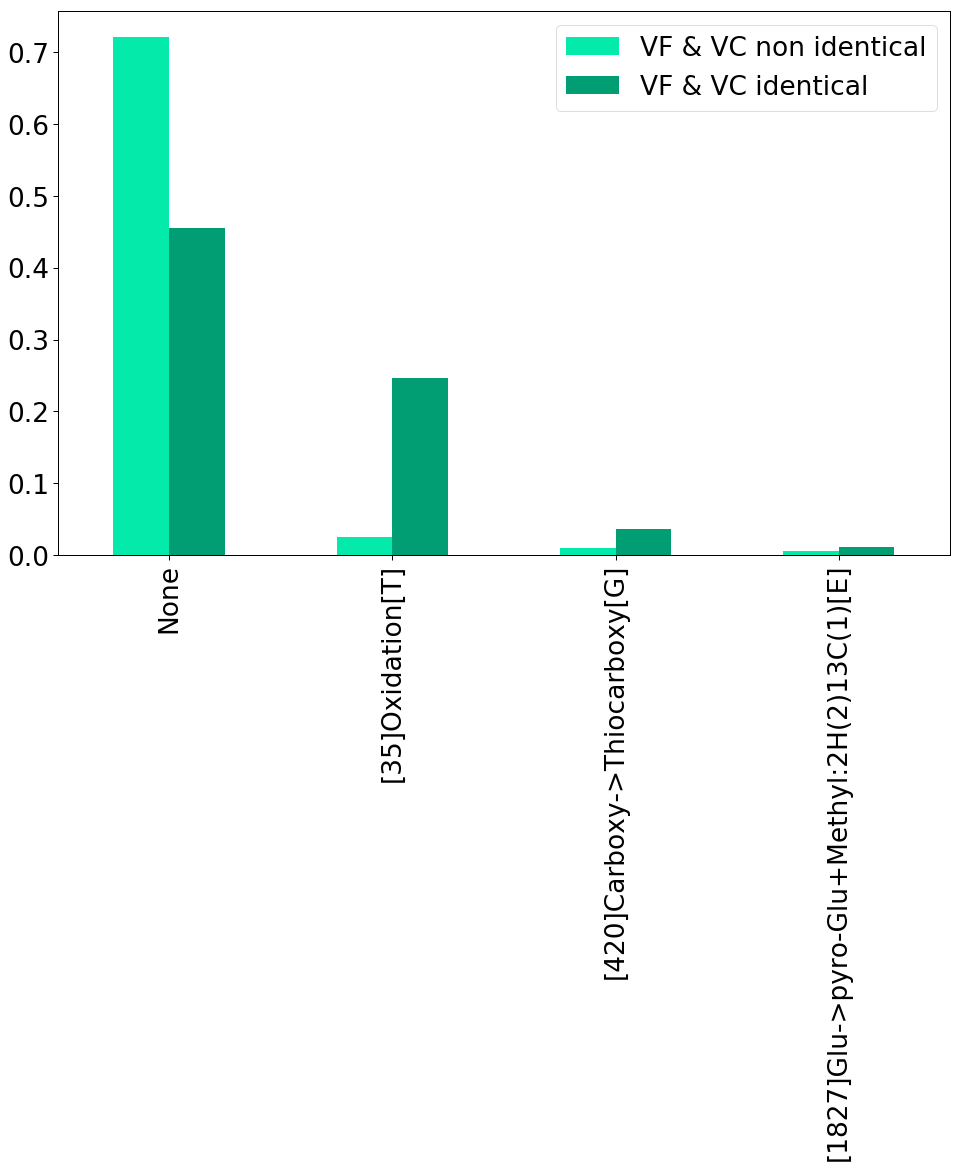

In [32]:
# Figure 6C
def parse_mods(expected,unexpected):
    out=[]
    exptd=['','[737]tmt6plex','[4]carbamidomethyl','[35]Oxidation','[35]oxidation[M]','[35]oxidation','[35]Oxidation[M]']
    if unexpected not in exptd:
        out.append(unexpected)
    expected=expected.split('|')
    for item in expected[1::2]:
        if item.strip() not in exptd:
            out.append(item)
    return(out)

sns.set_context('paper',font_scale=3)
# mds=prelim_vf[prelim_vf['matched_peptide_vf']!=prelim_vf['matched_peptide_vc']].fillna('').apply(lambda x: parse_mods(x['modifications_vc'],x['unexpected_modification_vc']),axis=1)
mds=pred_aa_wrong[pred_aa_wrong['matched_peptide_vf']!=pred_aa_wrong['matched_peptide_vc']].fillna('').apply(lambda x: parse_mods(x['modifications_vc'],x['unexpected_modification_vc']),axis=1)
# mds_inverse=prelim_vf[prelim_vf['matched_peptide_vf']==prelim_vf['matched_peptide_vc']].fillna('').apply(lambda x: parse_mods(x['modifications_vc'],x['unexpected_modification_vc']),axis=1)
mds_inverse=pred_aa_wrong[pred_aa_wrong['matched_peptide_vf']==pred_aa_wrong['matched_peptide_vc']].fillna('').apply(lambda x: parse_mods(x['modifications_vc'],x['unexpected_modification_vc']),axis=1)
# mds.explode().fillna('None').value_counts(normalize=True).head(15).to_frame(name='VF & VC disagree').merge(mds_inverse.explode().fillna('None').value_counts(normalize=True).head(15).to_frame(name='VC & VF agree reference peptide'),left_index=True,right_index=True).fillna(0).plot.bar(figsize=(16,10))
mds.explode().fillna('None').value_counts(normalize=True).head(15).to_frame(name='VF & VC non identical').merge(mds_inverse.explode().fillna('None').value_counts(normalize=True).head(15).to_frame(name='VF & VC identical'),left_index=True,right_index=True).fillna(0).plot.bar(color=['#03eaaa','#029e73'],figsize=(16,10))
# plt.xlabel('Unexpected modifications detected in the VC peptide')

In [30]:
pred_aa_wrong.drop_duplicates(subset='matched_peptide_vf')

,title,scan_id_vf,psm_id_vf,spec_psm_id_vf,matched_peptide_vf,modifications_vf,DB_vf,ionbot_score_vf,best_psm_vf,charge_vf,...,percolator_psm_score_vc,q_value_vc,PEP_vc,percolator_psm_score_best_vc,q_value_best_vc,PEP_best_vc,scan_id.1_vc,peptide_vc,source_dict_vc,variant_peptide
1,"Linfeng_030711_HapMap43_8.17433.17433.3 File:""...",134379.0,1.0,134379_1,IGGILANELSVDEAAVHAAVLAINEAVER,0|[737]tmt6plex|16|Val->Xle[V],False,0.425,1.0,3.0,...,3.486,0.000,0.000,8.054,0.000,0.000,134379.0,xGGxxANExSVDEAAxHAAVxAxNEAxDR,both,
2,"Linfeng_012111_HapMap38_9.23453.23453.3 File:""...",197600.0,1.0,197600_1,IGGILANELSVDEAAVHAAVLAINEAVER,0|[737]tmt6plex|16|Val->Xle[V],False,0.439,1.0,3.0,...,3.252,0.000,0.000,8.379,0.000,0.000,197600.0,xGGxxANExSVDEAAxHAAVxAxNEAxDR,both,
4,"Linfeng_111911_HapMap37_11.9126.9126.3 File:""L...",43733.0,2.0,43733_2,VGAGAPVYMAAVLEYLTAEILELAGNAAR,0|[737]tmt6plex|9|Met->Xle[M],False,0.535,1.0,3.0,...,3.342,0.000,0.000,8.407,0.000,0.000,43733.0,VGAGAPVYxAAVxEYxTAExxExAGNAAR,ref,
5,"Linfeng_010411_HapMap31_11.8768.8768.3 File:""L...",28528.0,2.0,28528_2,VGAGAPVYMAAVLEYLTAEILELAGNAAR,0|[737]tmt6plex|9|Met->Xle[M],False,0.545,1.0,3.0,...,3.281,0.000,0.000,7.584,0.000,0.000,28528.0,VGAGAPVYxAAVxEYxTAExxExAGNAAR,ref,
8,"Linfeng_030211_HapMap48_8.17635.17635.3 File:""...",132581.0,1.0,132581_1,IGGILANELSVDEAAVHAAVLAINEAVER,0|[737]tmt6plex|16|Val->Xle[V],False,0.453,1.0,3.0,...,3.024,0.000,0.000,7.532,0.000,0.000,132581.0,xGGxxANExSVDEAAxHAAVxAxNEAxDR,both,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42141,"Linfeng_010811_HapMap34_5.22180.22180.4 File:""...",107084.0,1.0,107084_1,ESDDPMAYIHFTAEGEVTFK,0|[737]tmt6plex|7|Ala->Ser[A]|20|[737]tmt6plex,False,0.180,1.0,4.0,...,0.464,0.000,0.002,1.391,0.000,0.001,107084.0,ESDDPMAYxHFTAEGEVTFK,both,
42142,"Linfeng_030911_HapMap46_4.12113.12113.3 File:""...",62634.0,2.0,62634_2,SAAEMYGSSFDLDYDFQR,0|[737]tmt6plex|7|Gly->Asn[G],False,0.230,1.0,3.0,...,0.398,0.000,0.003,1.278,0.000,0.001,62634.0,SAAEMYGSSFDxDYDFQR,both,
42143,"Linfeng_111710_HapMap21_6.20075.20075.3 File:""...",132222.0,1.0,132222_1,YPIEHGVVTNWDDMEK,0|[737]tmt6plex|14|[35]oxidation[M]|10|Asn->Ar...,False,0.109,1.0,3.0,...,-0.462,0.283,0.901,-0.532,0.068,0.883,132222.0,DAxSVPExNAxFGGAEEEK,ref,
42145,"Linfeng_080711_HapMap59_6.8695.8695.2 File:""Li...",129609.0,2.0,129609_2,EAIILAR,0|[737]tmt6plex|2|Ala->His[A],False,0.184,1.0,2.0,...,0.436,0.000,0.002,1.537,0.000,0.000,129609.0,EHxxxAR,both,


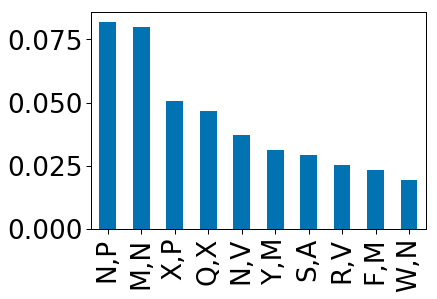

In [21]:
# Figure 6D/E - one with duplicate peptides and one without
p=pred_aa_wrong[pred_aa_wrong['matched_peptide_vf']!=pred_aa_wrong['matched_peptide_vc']].fillna('')
# p=mds[mds['matched_peptide_vf']!=mds['matched_peptide_vc']].fillna('')
p['class']=p.apply(lambda x: parse_mods(x['modifications_vc'],x['unexpected_modification_vc']),axis=1)
# p=p[p['class'].str.len()==0].drop_duplicates(subset='title') # NO UNEXPECTED MODIFICATIONS
p=p[p['class'].str.len()>0].drop_duplicates(subset='title').explode(column='class') # ANY UNEXPECTED MODIFICATIONS
# #statistics
p['ratio']=p['percolator_psm_score_best_vf']
# p[['peptide_vc']].rename({'peptide_vc':'variant_peptide'},axis=1).merge(variant_peptides[['variant_peptide','substitution']],on='variant_peptide')
pdup=p[['matched_peptide_vf','pred_aa_sub']].drop_duplicates()
pdup['pred_aa_sub'].value_counts(normalize=True).head(10).plot.bar()

In [19]:
# Figure 6F-
#plotting
p['delta_rt']=(p['rt_predicted_vf']-p['rt_vf']).abs()
p.plot.scatter(x='percolator_psm_score_best_vf',y='percolator_psm_score_best_vc',c='delta_rt',colormap='viridis',figsize=(16, 10))
left, right = plt.xlim()
x = np.linspace(left,right)
plt.plot(x, x)

KeyError: 'rt_predicted_vf'

In [4]:
# Figure 7A
#imports
import io
def match_var_nonvar(df_var,df_nonvar,var_pep_df):
    pep_ct_var=df_var['variant_peptide'].value_counts().reset_index()
    pep_ct_var.columns=['variant_peptide','count_var']
    var_pep_df=var_pep_df.merge(pep_ct_var,on='variant_peptide',how='left')
    pep_ct_refctp=df_nonvar['ref_counterpart'].value_counts().reset_index()
    pep_ct_refctp.columns=['ref_counterpart','count_refctp']
    var_pep_df=var_pep_df.merge(pep_ct_refctp,on='ref_counterpart',how='left').fillna(0)
    return(var_pep_df[var_pep_df['count_var']!=0].drop(columns=['id','haplotype']).drop_duplicates(subset='variant_peptide'))

def read_vep(path):
    with open(path, 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(io.StringIO(''.join(lines)),sep='\t').rename(columns={'#Uploaded_variation': 'Uploaded_variation'})

final_counterpartset_vc=pd.read_csv('~/Dropbox/ionbot/with_crap/variants_vc_ctp.csv').drop_duplicates('title')
final_counterpartset_vf=pd.read_csv('~/Dropbox/ionbot/with_crap/variants_vf_ctp.csv').drop_duplicates('title')
vf_vvv=match_var_nonvar(final_variantset_vf,final_counterpartset_vf,variant_peptides)
vc_vvv=match_var_nonvar(final_variantset_vc,final_counterpartset_vc,variant_peptides)
vvv=vc_vvv.merge(vf_vvv[['variant_peptide','count_var','count_refctp']],on='variant_peptide',how='outer',suffixes=('_vc','_vf')).fillna(0).drop_duplicates()

var_anno=pd.read_csv('~/Downloads/var_anno.csv') #annovar results
var_anno['variant_origin']=var_anno['Chr']+'|'+var_anno['Start'].astype(str)
observed_anno=vvv.merge(var_anno[['variant_origin','Gene.ensGene','1000G_ALL','ExAC_Freq','dbSNP','ClinVar_SIG','SIFT_score','SIFT_pred','FATHMM_score','FATHMM_pred','PROVEAN_score', 'PROVEAN_pred','MetaSVM_score','MetaSVM_pred','MetaLR_score','MutationTaster_pred','MutationAssessor_pred','Interpro_domain','GTEx_V6_gene','GTEx_V6_tissue','gnomAD_exome_ALL']],on='variant_origin')
deleterious=observed_anno[observed_anno['PROVEAN_pred']=='D'] #can switch which pred you use here
d=deleterious[(deleterious['var_type']=='heterozygous')&(deleterious['count_var_vc']>0)&(deleterious['count_refctp_vc']>0)]
d['ratio']=d['count_refctp_vc']/d['count_var_vc']
# stats.f_oneway(s3['ratio'],d['ratio'])


/Users/rsalz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
# get labels for plot
from scipy import optimize
def lin_fit(x, y):
    '''Fits a linear fit of the form mx+b to the data'''
    fitfunc = lambda params, x: params[0] * x    #create fitting function of form mx+b
    errfunc = lambda p, x, y: fitfunc(p, x) - y              #create error function for least squares fit

    init_a = 0.5                            #find initial value for a (gradient)
    init_p = np.array((init_a))  #bundle initial values in initial parameters

    #calculate best fitting parameters (i.e. m and b) using the error function
    p1, success = optimize.leastsq(errfunc, init_p.copy(), args = (x, y))
    f = fitfunc(p1, x)          #create a fit with those parameters
    return p1

sect1=vf_vvv[vf_vvv['var_type']=='heterozygous'] # vf het
sect2=vf_vvv[vf_vvv['var_type']=='homozygous'] # vf hom
sect3=vc_vvv[vc_vvv['var_type']=='heterozygous'] # vc het
sect4=vc_vvv[vc_vvv['var_type']=='homozygous'] # vc hom


display(lin_fit(sect1['count_var'],sect1['count_refctp']))
display(lin_fit(sect2['count_var'],sect2['count_refctp']))
display(lin_fit(sect3['count_var'],sect3['count_refctp']))
display(lin_fit(sect4['count_var'],sect4['count_refctp']))
display(sect1.shape[0])
display(sect2.shape[0])
display(sect3.shape[0])
display(sect4.shape[0])

array([1.45063815])

array([0.49026683])

array([0.61963724])

array([0.01428155])

29

33

234

176

<Figure size 2304x1440 with 0 Axes>

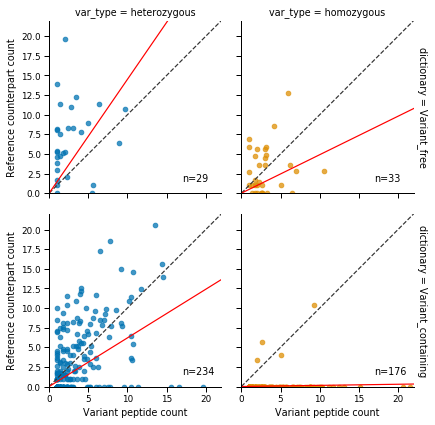

In [24]:
def plot_mut_vs_nonmut(counts_vf,counts_vc,lim=22):
    # I input the plot labels by hand in here
    counts_vf['dictionary']='Variant_free'
    counts_vc['dictionary']='Variant_containing'
    counts=pd.concat([counts_vf,counts_vc])
    counts['count_var']=np.sqrt(counts['count_var'])
    counts['count_refctp']=np.sqrt(counts['count_refctp'])
    # sns.set(style="white", color_codes=True)
    plt.figure(figsize=(32, 20))
    sns.set_context("paper",font_scale=1)
    g = sns.FacetGrid(counts, col="var_type",row='dictionary',hue='var_type',margin_titles=True)#,size=7)
    g.map(plt.scatter,'count_var','count_refctp',alpha=0.75)
    for ax in g.axes.flat:
        ax.plot((0, lim), (0, lim), c=".2", ls="--")
    ax1,ax2=g.axes[0]
    ax3,ax4=g.axes[1]
    x=np.linspace(0,lim,100)
    ax1.plot(x, 1.45063815*x, '-r', label='y=1.45063815x')
    ax1.text(17,1.5, "n=29")
    ax2.plot(x, 0.49026683*x, '-r', label='y=0.49026683x')
    ax2.text(17,1.5, "n=33")
    ax3.plot(x, 0.61963724*x, '-r', label='y=0.61963724x')
#     ax3.scatter(np.sqrt(ASE['count_var_vc']),np.sqrt(ASE['count_refctp_vc']),color='red',marker='*')
    ax3.text(17,1.5, "n=234")
    ax4.plot(x, 0.01428155*x, '-r', label='y=0.01428155x')
    ax4.text(17,1.5, "n=176")
    g.set(xlim=(0,lim), ylim=(0,lim))
#     g.set(xscale = 'log',yscale = 'log')
#     g.set(xlim=(3,-1), ylim=(3,-1))
    g.set_axis_labels('Variant peptide count', 'Reference counterpart count')
#     plt.title('Variant vs. non-variant peptide abundance')
    plt.tight_layout()

plot_mut_vs_nonmut(match_var_nonvar(final_variantset_vf,final_counterpartset_vf,variant_peptides),match_var_nonvar(final_variantset_vc,final_counterpartset_vc,variant_peptides))

/Users/rsalz/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'Allele frequency')

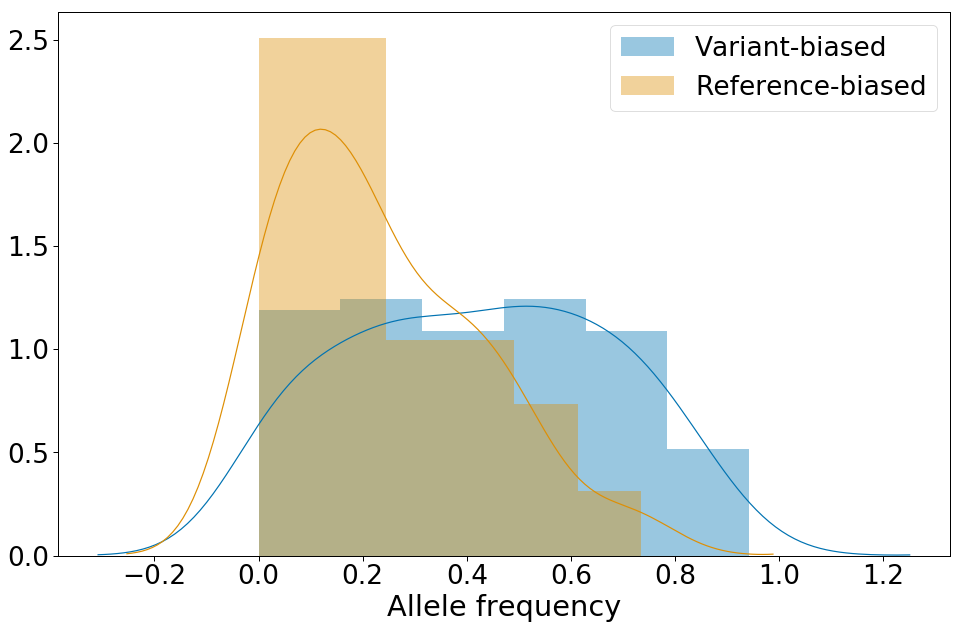

In [25]:
# Figure 7B
sns.set_context('paper',font_scale=3)
plt.figure(figsize=(16, 10))
score='PROVEAN_score'
bias_ref_sect3=sect3[sect3['count_refctp']>sect3['count_var']].merge(var_anno,on='variant_origin')
bias_var_sect3=sect3[sect3['count_refctp']<sect3['count_var']].merge(var_anno,on='variant_origin')
bias_var_sect3=bias_var_sect3[(bias_var_sect3[score]!='.')&(bias_var_sect3['gnomAD_exome_ALL']!='.')]
bias_ref_sect3=bias_ref_sect3[(bias_ref_sect3[score]!='.')&(bias_ref_sect3['gnomAD_exome_ALL']!='.')]
sns.distplot(bias_var_sect3['gnomAD_exome_ALL'].astype(float))
sns.distplot(bias_ref_sect3['gnomAD_exome_ALL'].astype(float))
# sns.distplot(no_ref_pep['gnomAD_exome_ALL'].astype(float))
plt.legend(labels=['Variant-biased','Reference-biased','No reference'],loc='upper right')
plt.xlabel('Allele frequency')

In [29]:
display(bias_var_sect3.shape[0])
display(bias_ref_sect3.shape[0])

#p-value allele frequency difference
display(stats.f_oneway(bias_var_sect3['gnomAD_exome_ALL'].astype(float),bias_ref_sect3['gnomAD_exome_ALL'].astype(float)))


123

78

F_onewayResult(statistic=31.56241619185269, pvalue=6.449132442573135e-08)

/Users/rsalz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/rsalz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


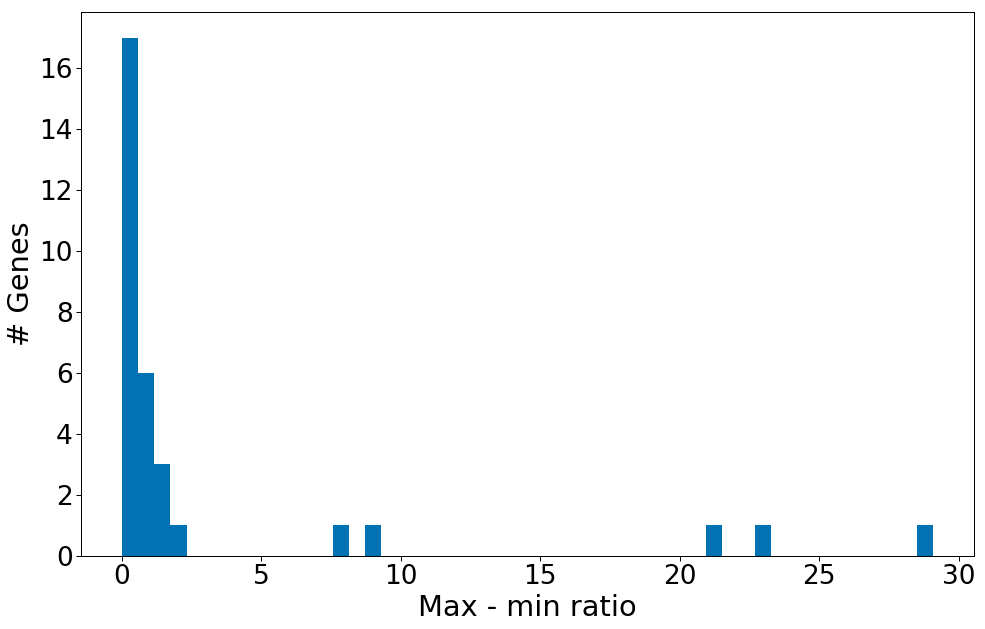

In [5]:
# Figure 7C
def bar_genegroups_hist(df):
    sns.set_context('paper',font_scale=3)
    df['ratio']=df['count_refctp_vc']/df['count_var_vc']
    df['ratio']=df.groupby('Gene.ensGene')['ratio'].transform(lambda x: (x.max()-x.min()))#.merge(df,right_on='Gene.ensGene',left_index=True)
#     df['ratio']=df['ratio']*
#     plt.figure()
    df=df.drop_duplicates(subset='Gene.ensGene')
    df['ratio'].plot.hist(bins=50,legend=False,figsize=(16, 10))
    plt.xlabel('Max - min ratio')
    plt.ylabel('# Genes')

d=pd.DataFrame(observed_anno.loc[(observed_anno['count_var_vc']>2)|(observed_anno['count_var_vc']>2),'Gene.ensGene'].value_counts().sort_values(ascending=False))
d=d[d['Gene.ensGene']>1] #isolate genes with multiple variant peptides detected
bar_genegroups_hist(observed_anno[observed_anno['Gene.ensGene'].isin(list(d.index))])

/Users/rsalz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/rsalz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


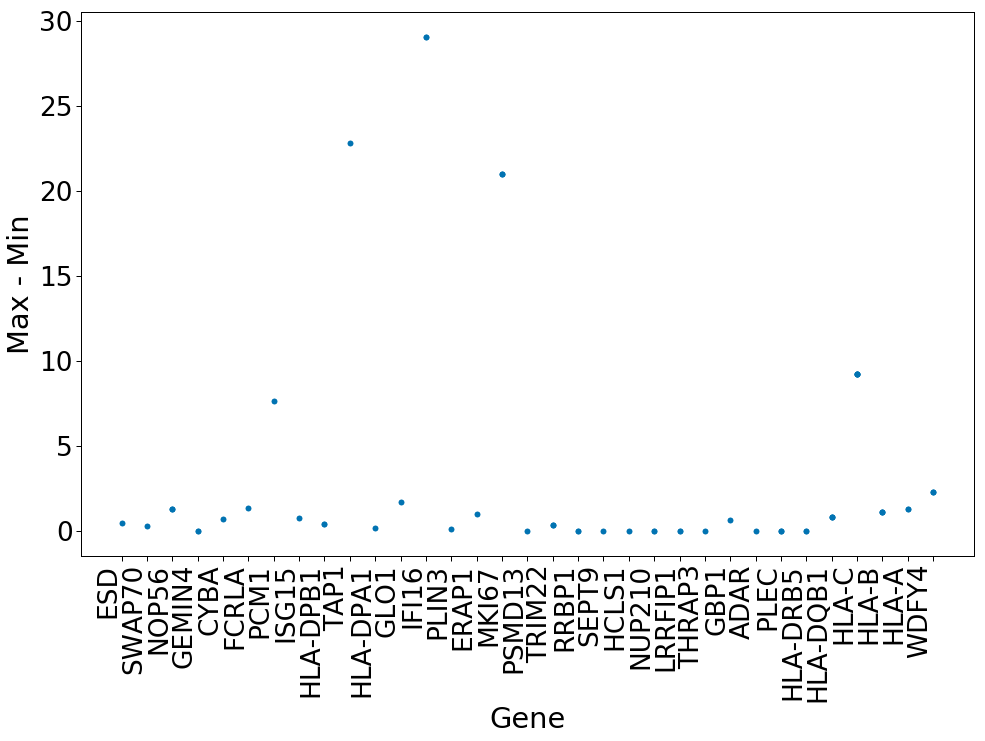

In [34]:
# Figure 7D
def bar_genegroups(df):
    sns.set_context('paper',font_scale=3)
    df['ratio']=df['count_refctp_vc']/df['count_var_vc']
    df['ratio']=df.groupby('Gene.ensGene')['ratio'].transform(lambda x: (x.max()-x.min()))#.merge(df,right_on='Gene.ensGene',left_index=True)
#     df['ratio']=df['ratio']*
#     plt.figure()
    d=df[['Gene.ensGene','ratio']].drop_duplicates()
#     df[['Gene.ensGene','ratio']].drop_duplicates().set_index('Gene.ensGene').plot.hist(legend=False,figsize=(16, 10))#.sort_values(by='ratio',ascending=False)
    plt.figure(figsize=(16, 10))
    plt.scatter(df['Gene.ensGene'],df['ratio'])
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('Max - Min')
    plt.xlabel('Gene')
    
bar_genegroups(observed_anno[observed_anno['Gene.ensGene'].isin(list(d.index))]) 

In [6]:
#checking out the genes with inconsistent variant peptide ratios
def strip_protlist(protlist):
    newp=[]
    p=protlist.split('||')
    for item in p:
        newp.append(item.split('((')[0])
    return('||'.join(newp))

cat_prot=observed_anno[['count_var_vc','count_refctp_vc','peptide_original']].rename({'peptide_original':'matched_peptide'},axis=1).merge(final_variantset_vc[['matched_peptide','proteins']],on='matched_peptide').drop_duplicates('matched_peptide')
cat_prot['bare_prot']=cat_prot['proteins'].apply(strip_protlist)
cat_prot=cat_prot.groupby('bare_prot').agg('sum').reset_index()

df=observed_anno[observed_anno['Gene.ensGene'].isin(list(d.index))]
df['ratio']=df['count_refctp_vc']/df['count_var_vc']
df['ratio']=df.groupby('Gene.ensGene')['ratio'].transform(lambda x: (x.max()-x.min()))#.merge(df,right_on='Gene.ensGene',left_index=True)
df=df.loc[df['ratio']>5,('variant_peptide','peptide_original','Gene.ensGene','ratio')].rename({'peptide_original':'matched_peptide'},axis=1)
df=df.merge(final_variantset_vc[['matched_peptide','proteins','percolator_psm_score_best']],on='matched_peptide').drop_duplicates('variant_peptide')
df['bare_prot']=df['proteins'].apply(strip_protlist)
df=df.merge(cat_prot.reset_index(),on='bare_prot')#.drop_duplicates('bare_prot')
df.columns

/Users/rsalz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/rsalz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Index(['variant_peptide', 'matched_peptide', 'Gene.ensGene', 'ratio',
       'proteins', 'percolator_psm_score_best', 'bare_prot', 'index',
       'count_var_vc', 'count_refctp_vc'],
      dtype='object')

In [89]:
df['prot']=df['proteins'].str.split('\|{2}')
df['num_hits']=df['prot'].str.len()

In [15]:
df['num_hits'].mean()

6.0

In [17]:
avgs=final_variantset_vc['proteins'].str.split('\|{2}')
avgs=avgs.str.len()
avgs.mean()

5.3711432850723915

In [7]:
df.shape[0]

17

In [92]:
df.drop_duplicates('bare_prot')

,variant_peptide,matched_peptide,Gene.ensGene,ratio,proteins,percolator_psm_score_best,bare_prot,index,count_var_vc,count_refctp_vc,prot,num_hits
0,SKDASTSPPNR,SKDASTSPPNR,PCM1,7.611111,ENST00000518537.5|h.0((153-164))||ENST00000519...,1.309,ENST00000518537.5|h.0||ENST00000519253.5|h.0||...,295,21.0,24.0,"[ENST00000518537.5|h.0((153-164)), ENST0000051...",24
2,SGAHSFxSGxPQGYDTEVGEAGSQxSGGQR,SGAHSFISGLPQGYDTEVGEAGSQLSGGQR,TAP1,22.850000,ENST00000354258.4|h.0((679-709))||ENST00000354...,7.117,ENST00000354258.4|h.0||ENST00000354258.4_ENSG0...,125,41.0,268.0,"[ENST00000354258.4|h.0((679-709)), ENST0000035...",3
4,xKTEPEEVFxEDSAQSDxK,LKTEPEEVFIEDSAQSDLK,IFI16,29.081159,ENST00000359709.7|h.0((504-523))||ENST00000368...,2.570,ENST00000359709.7|h.0||ENST00000368131.8|h.0||...,136,10.0,104.0,"[ENST00000359709.7|h.0((504-523)), ENST0000036...",11
6,YENESxQSGR,YENESLQSGR,MKI67,21.000000,ENST00000368653.7|h.0((97-107))||ENST000003686...,3.205,ENST00000368653.7|h.0||ENST00000368654.7|h.0,163,39.0,6.0,"[ENST00000368653.7|h.0((97-107)), ENST00000368...",2
7,xTQTSGESTHTDKEPVGEGK,LTQTSGESTHTDKEPVGEGK,MKI67,21.000000,ENST00000368653.7|h.0((2501-2521))||ENST000003...,2.769,ENST00000368653.7|h.0||ENST00000368654.7|h.0||...,164,38.0,34.0,"[ENST00000368653.7|h.0((2501-2521)), ENST00000...",3
10,TSxSAPPNTSSTENPK,TSLSAPPNTSSTENPK,IFI16,29.081159,ENST00000368131.8|h.1((171-187))||ENST00000295...,4.379,ENST00000368131.8|h.1||ENST00000295809.11|h.1|...,159,115.0,29.0,"[ENST00000368131.8|h.1((171-187)), ENST0000029...",7
11,QAQTDR,QAQTDR,HLA-C,9.235294,ENST00000376228.9|h.0((94-100))||ENST000003833...,0.755,ENST00000376228.9|h.0||ENST00000383329.7|h.0||...,187,4.0,2.0,"[ENST00000376228.9|h.0((94-100)), ENST00000383...",3
12,GYDQYAYDGK,GYDQYAYDGK,HLA-C,9.235294,ENST00000376228.9|h.0((136-146))||ENST00000383...,2.909,ENST00000376228.9|h.0||ENST00000383329.7|h.0,186,74.0,483.0,"[ENST00000376228.9|h.0((136-146)), ENST0000038...",2
15,ETQNYK,ETQNYK,HLA-C,9.235294,ENST00000376228.9|h.1((87-93))||ENST0000038332...,1.096,ENST00000376228.9|h.1||ENST00000383329.7|h.1||...,189,40.0,0.0,"[ENST00000376228.9|h.1((87-93)), ENST000003833...",3
16,MYGCDxGPDGR,MYGCDLGPDGR,HLA-C,9.235294,ENST00000376228.9|h.1((122-133))||ENST00000383...,3.279,ENST00000376228.9|h.1||ENST00000383329.7|h.1,188,277.0,0.0,"[ENST00000376228.9|h.1((122-133)), ENST0000038...",2


In [22]:
len(set(df.proteins.sum()))

78

In [8]:
# checking out the variant-only peptides
interest=observed_anno[(observed_anno['var_type']=='heterozygous')&(observed_anno['count_refctp_vc']==0)&(observed_anno['count_var_vc']>2)]


In [10]:
interest['substitution'].str.contains('R|K',regex=True).value_counts()
interest.shape[0] #number of these variant-only peptides
interest['variant_origin'].value_counts().head() #some of these peptides are in twice - 2 alt alleles instead of 1 alt and 1 ref

chr6|31271324     2
chr6|32664910     2
chr6|31356366     2
chr14|73718893    1
chr16|3674464     1
Name: variant_origin, dtype: int64

In [24]:
interest.loc[interest['variant_origin']=='chr6|31356366','Gene.ensGene']
# variant_peptides[variant_peptides['variant_origin']=='chr6|32664910']

373    HLA-B
374    HLA-B
Name: Gene.ensGene, dtype: object

In [25]:
len(interest['Gene.ensGene'].unique())

37

In [18]:
interest[interest['variant_origin']=='chr6|31356366']

,variant_peptide,ref_counterpart,substitution,variant_origin,var_type,peptide_original,ref_counterpart_original,count_var_vc,count_refctp_vc,count_var_vf,...,PROVEAN_pred,MetaSVM_score,MetaSVM_pred,MetaLR_score,MutationTaster_pred,MutationAssessor_pred,Interpro_domain,GTEx_V6_gene,GTEx_V6_tissue,gnomAD_exome_ALL
373,GHNQYAYDGKDYxAxNEDxR,GHDQYAYDGKDYxAxNEDxR,"N,D",chr6|31356366,heterozygous,GHNQYAYDGKDYIALNEDLR,GHDQYAYDGKDYIALNEDLR,387.0,0.0,4.0,...,.,.,.,.,A,.,MHC class I alpha chain\x2c alpha1 alpha2 doma...,.,.,0.0547
374,GHNQYAYDGK,GHDQYAYDGK,"N,D",chr6|31356366,heterozygous,GHNQYAYDGK,GHDQYAYDGK,130.0,0.0,0.0,...,.,.,.,.,A,.,MHC class I alpha chain\x2c alpha1 alpha2 doma...,.,.,0.0547


In [48]:
score_dist=interest[['variant_peptide']].drop_duplicates().merge(final_variantset_vc[['variant_peptide','percolator_psm_score_best']].drop_duplicates(),on='variant_peptide')

/Users/rsalz/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,0,'PSM score')

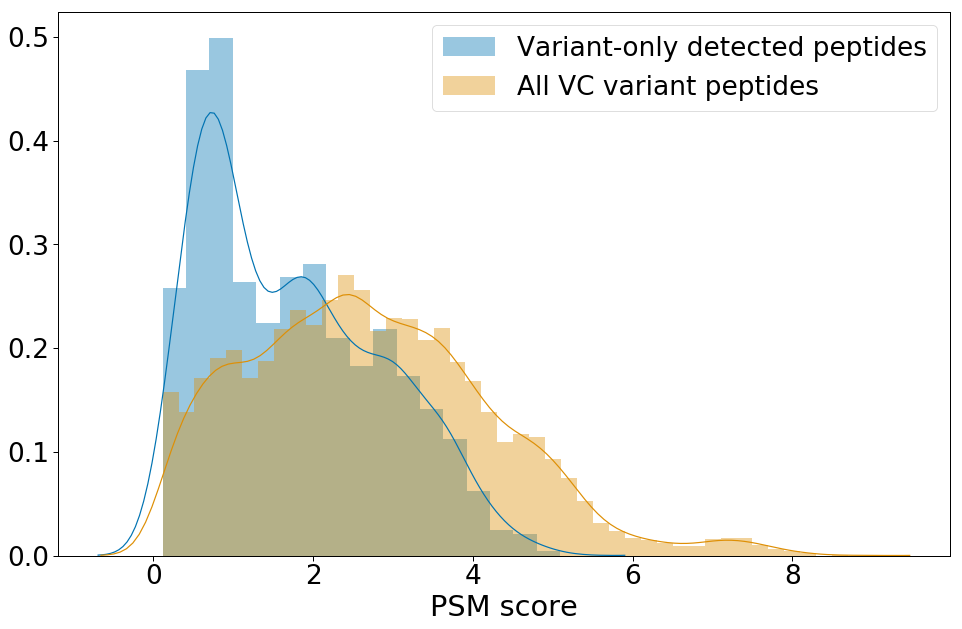

In [53]:
sns.set_context('paper',font_scale=3)
plt.figure(figsize=(16, 10))
sns.distplot(score_dist['percolator_psm_score_best'])
sns.distplot(final_variantset_vc['percolator_psm_score_best'])
plt.legend(labels=['Variant-only detected peptides','All VC variant peptides'],loc='upper right')
plt.xlabel('PSM score')